# XGBoost Model - Energy Cost Prediction with Time Series

### Importing needed libraries

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

### Reading data and set index

- the datetime column of our data is put as the index, because it is consistent
- changing the index from type 'object' to type 'datetime'

In [330]:
df = pd.read_csv(
    "C:/Users/zawad/OneDrive/Desktop/team-6-energy-costs/data/prepared/df_energy_climate_2020.csv")
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

### Visualize our data - energy price transition 2020

<AxesSubplot:title={'center':'Energy price in 2020'}, xlabel='datetime'>

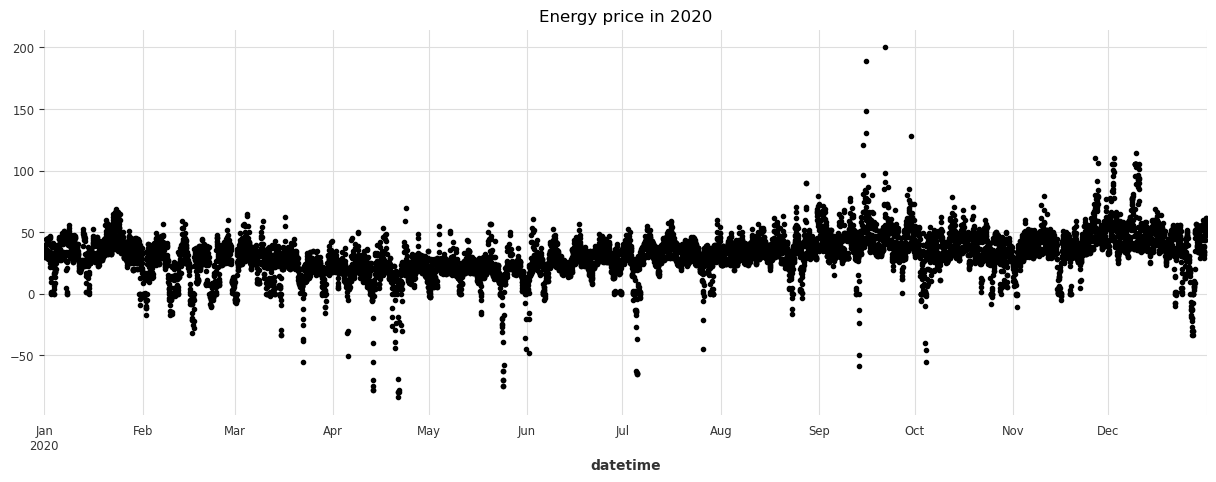

In [258]:
color_pal = sns.color_palette()
df['energy_price'].plot(
    style='.', 
    figsize=(15, 5),
    color=color_pal[0], # type: ignore
    title='Energy price in 2020'
)

### Train / Test Split

- Split the data into Train : Test = 8 : 2

In [331]:
splitting_point = (int(len(df)*0.2))
train, test = df[:-splitting_point], df[-splitting_point:]

### Visualize train and test data

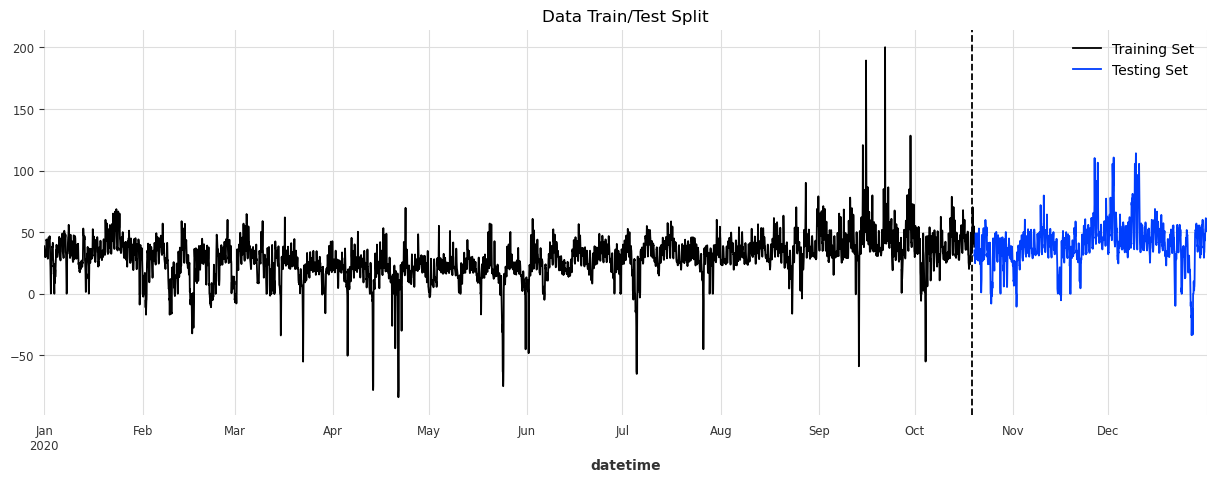

In [260]:
fig, ax = plt.subplots(figsize =(15, 5))
train.plot(ax=ax, y='energy_price', label = 'Training Set', title='Data Train/Test Split')
test.plot(ax=ax, y='energy_price', label = 'Testing Set')
ax.axvline('2020-10-19', color='black', ls='--') # type: ignore
plt.show()

In [332]:
df.index[-splitting_point]

Timestamp('2020-10-19 20:00:00')

### Create features

- Target = Energy price
- Features = hour, day, week

In [333]:
def create_features(df):
    '''
    create time series features based on time series index
    '''
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

df = create_features(df)

### Set features and target

- Target = energy price
- Features = hour, day, week

In [334]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'month']
TARGET = 'energy_price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### Create model

In [267]:
# Set random state to ensure reproductivity
reg = xgb.XGBRegressor(random_state=0)

### Train model and make predictions

In [268]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:24.12732	validation_1-rmse:33.18543
[99]	validation_0-rmse:9.25153	validation_1-rmse:16.65789


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

### Visualize truth and predictions

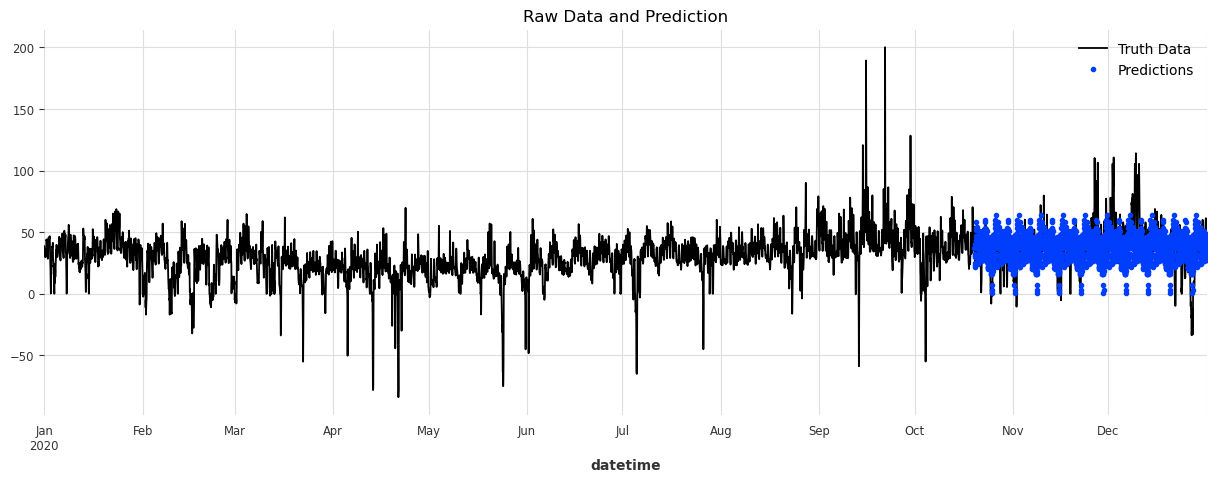

In [269]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

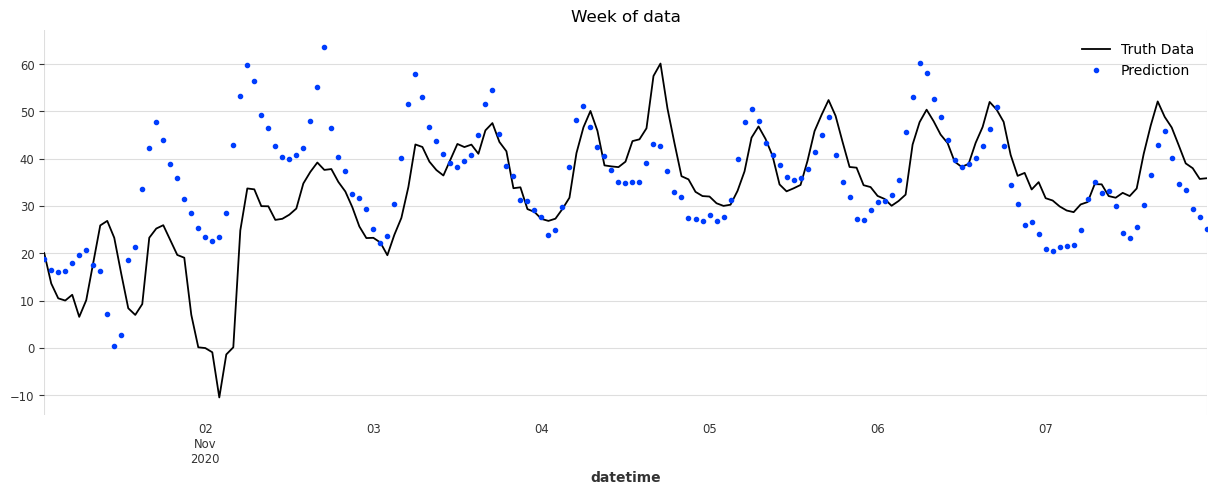

In [270]:
ax = df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

### Evaluate model

- For evaluation we use:
    - RMSE 
    - MAPE


- RMSE (Root Mean Squared Error)
    - Measures the average distance between the predicted values and the actual values (squared difference is taking into account)
    - RMSE gives more weight to **larger errors** and is useful when it is important to minimize the impact of large errors
    - It can be heavily influenced by outliers
    - Useful when comparing the performance of different models
    - It is not always easy to interpret the magnitude of the error as it is not a percentage
    
    
- MAPE (Mean Absolute Percentae Error)
    - Measures the average percentage difference between the predicted values and actual values
    - Useful when the data contains different scales or magnitudes, as it normalizes the error by the actual value
    - It is more interpretable
    - It may be undefined or produce very large values when the actual values are close to zero
    - It is not symmetric => The errors in the predicted values may not be weighted equally in both directions

In [271]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 16.66
MAPE Score on test set: 11.70


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |  

### Searching for hyperparameters

What are hyperparameters?
- They re not lerned by the model during the training but set beforehand by the user or the researcher
- They can have a significant impact on the performance of the model 

In [273]:
reg_hyper_p = xgb.XGBRegressor(random_state=0)

- We use grid search
- We search for the best parameters for 
    - n_estimators: the number of trees built before taking the maximum voting or averages of predictions
    - max_depth: the longest path between the root node and the leaf node 
    - gamma: controls minimum loss reduction required to split a node during tree construction
    - learning_rate: used to govern the pace at which an algorithm updates or learns the values of a parameter estimate

In [275]:
# make a dictionary of hyperparameter values to search
search_space = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'gamma': [0.01, 0.1],
    'learning_rate': [0.001, 0.01, 0.1],
}

GS = GridSearchCV(estimator = reg_hyper_p,
                  param_grid = search_space,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit = 'r2', # type: ignore
                  cv = 5,
                #   verbose=4
)

In [276]:
GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [277]:
print(GS.best_params_)

{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


### Create model with hyperparameters

In [282]:
reg_hyper_p = xgb.XGBRegressor(
    gamma=0.1,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    random_state=0
)

In [283]:
reg_hyper_p.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:32.00740	validation_1-rmse:42.73430
[100]	validation_0-rmse:16.79386	validation_1-rmse:22.23874
[200]	validation_0-rmse:12.84260	validation_1-rmse:17.54612
[300]	validation_0-rmse:11.78742	validation_1-rmse:16.36642
[400]	validation_0-rmse:11.32280	validation_1-rmse:15.99089
[499]	validation_0-rmse:11.03981	validation_1-rmse:15.88613


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

### Visualize truth and prediction

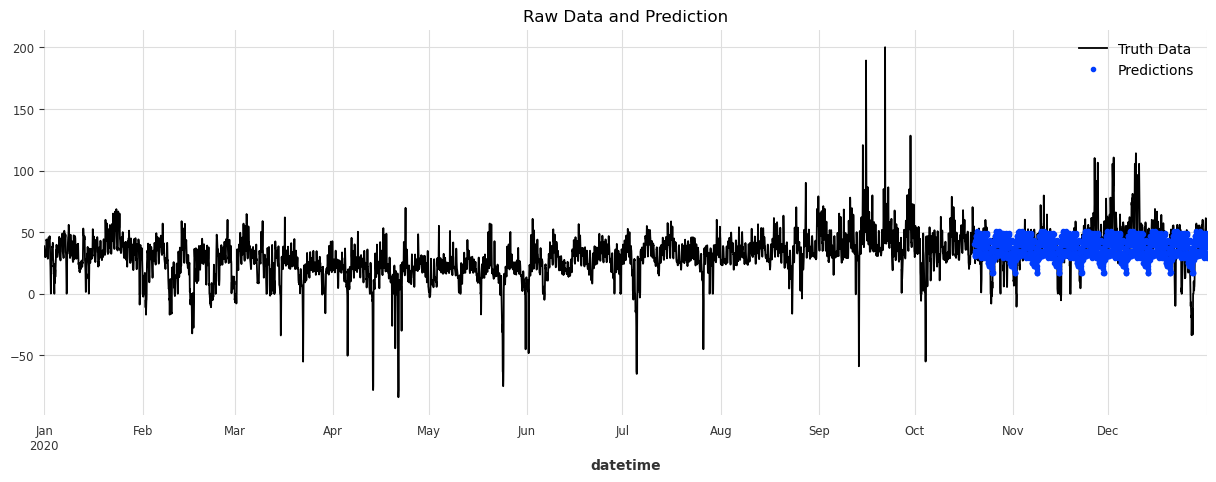

In [284]:
test['prediction_hyp'] = reg_hyper_p.predict(X_test)
df = df.merge(test[['prediction_hyp']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction_hyp'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

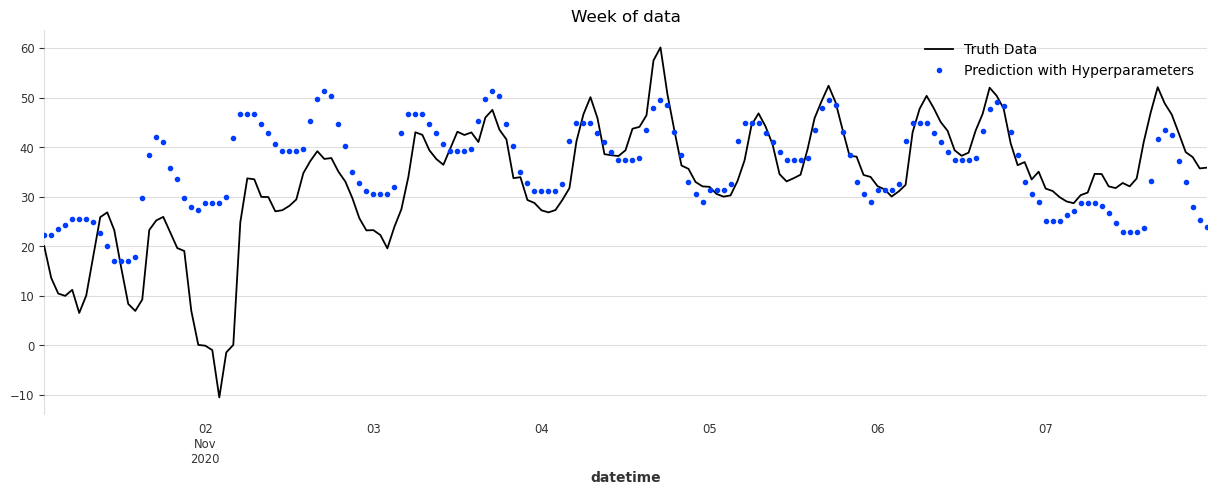

In [285]:
ax = df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['prediction_hyp'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction with Hyperparameters'])
plt.show()

In [286]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction_hyp']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction_hyp']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 15.89
MAPE Score on test set: 12.59


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 2 with hyperparameters|15.89 | 12.59% |          

### RMSE improved slightly, but MAPE worsened. What does it mean?
This may occur when the model is accurately predicting the values close to the actual values, but making larger errors for the values that are farther from the actual values.

### Removing outliers

<AxesSubplot:ylabel='Frequency'>

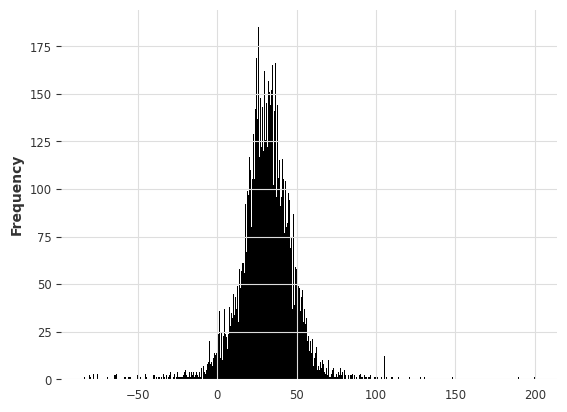

In [335]:
df['energy_price'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='datetime'>

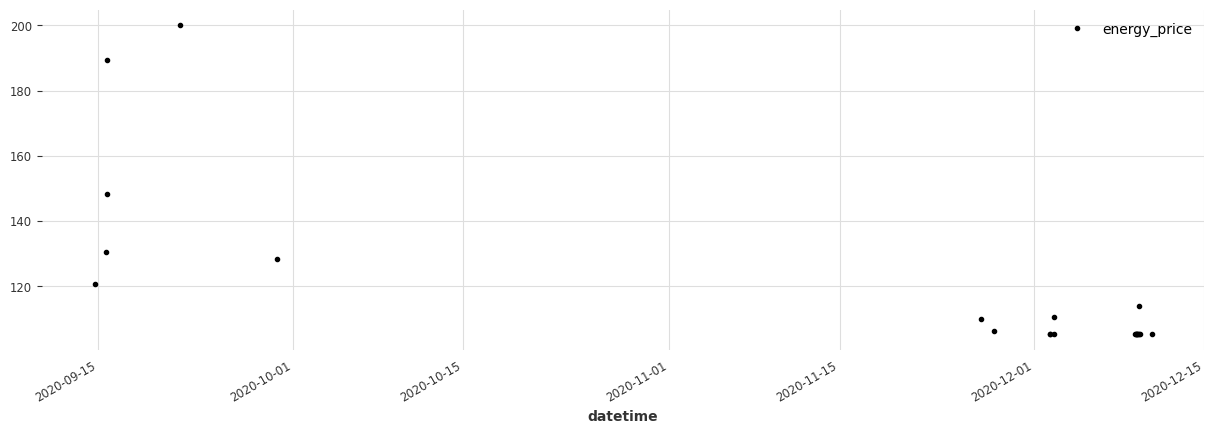

In [336]:
df.query('energy_price > 105').plot(y='energy_price', figsize=(15, 5), style='.')

<AxesSubplot:xlabel='datetime'>

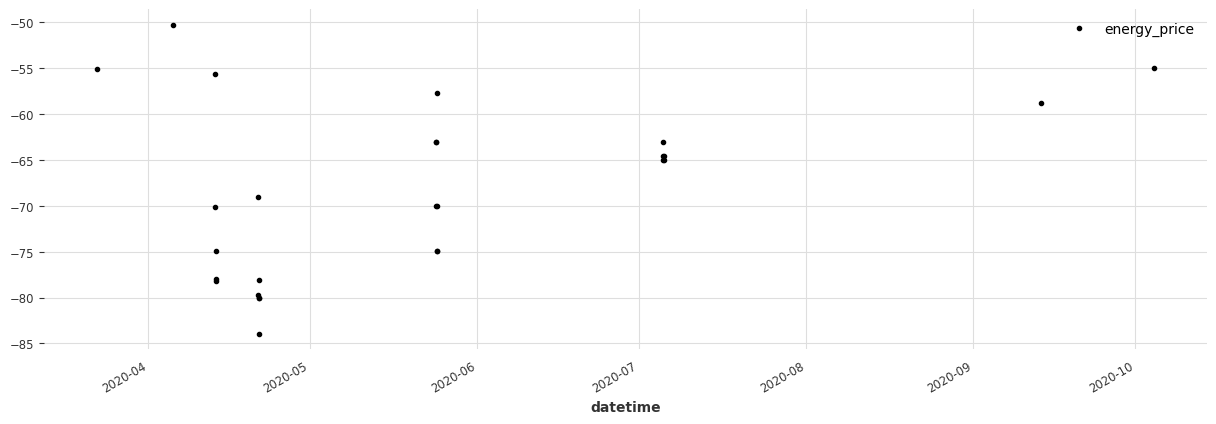

In [289]:
df.query('energy_price < -50').plot(y='energy_price', figsize=(15, 5), style='.')

In [337]:
df = df.query('energy_price < 105').copy()
df = df.query('energy_price > -50').copy()

### Testing Model with hyperparameters again without outliers

In [291]:
splitting_point = (int(len(df)*0.2))
train, test = df[:-splitting_point], df[-splitting_point:]
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg_hyper_p.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:31.44445	validation_1-rmse:41.75793
[100]	validation_0-rmse:15.61550	validation_1-rmse:21.23021
[200]	validation_0-rmse:11.40722	validation_1-rmse:16.40137
[300]	validation_0-rmse:10.29960	validation_1-rmse:15.17997
[400]	validation_0-rmse:9.84126	validation_1-rmse:14.80518
[499]	validation_0-rmse:9.58565	validation_1-rmse:14.70650


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

### Visualize truth and prediction

C:\Users\zawad\AppData\Local\Temp\ipykernel_12228\2643222670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_less_outliers'] = reg_hyper_p.predict(X_test)


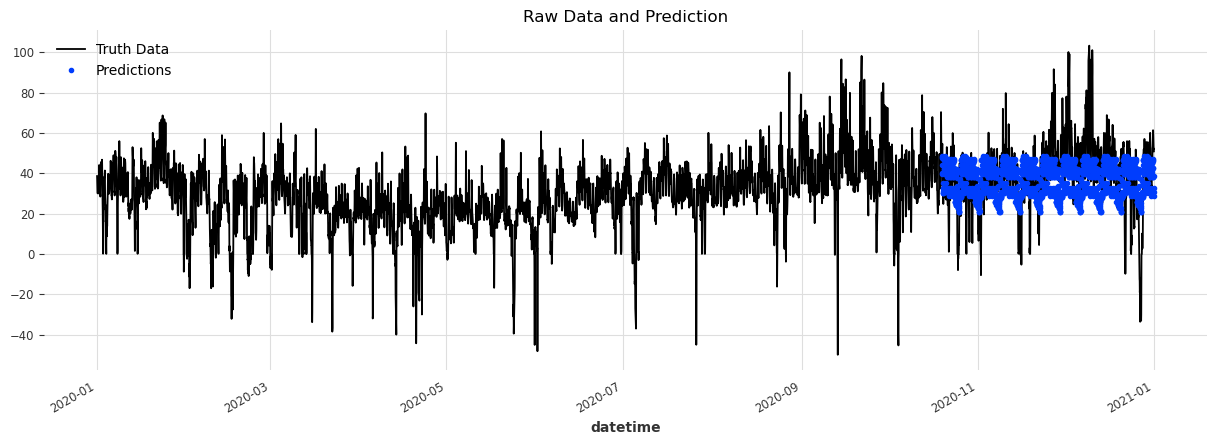

In [292]:
test['prediction_less_outliers'] = reg_hyper_p.predict(X_test)
df = df.merge(test[['prediction_less_outliers']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction_less_outliers'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [293]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction_less_outliers']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction_less_outliers']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 14.71
MAPE Score on test set: 12.66


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.71  |12.66%  | 

### Time Series Cross Validation

What is Cross Validation?
- Cross-validation is an essential technique used in machine learning to evaluate the performance of a model on unseen data.

Benefits of Cross Validation
- It provides a more accurate estimate of a model's performance on new data
- Helps to identify overfitting
- Allows for tuning of hyperparameters to optimize model performance

In [338]:
#n_splits = the model will do 5 folds of cross validation
#test_size = as we have an hourly dataset and we want to predict one week so we set the test_size = 168 (hours in one week)
#gap = gap between train and test data to prevent data leakage

tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)
df = df.sort_index()

- visualizing the folds of the model to see how each fold works

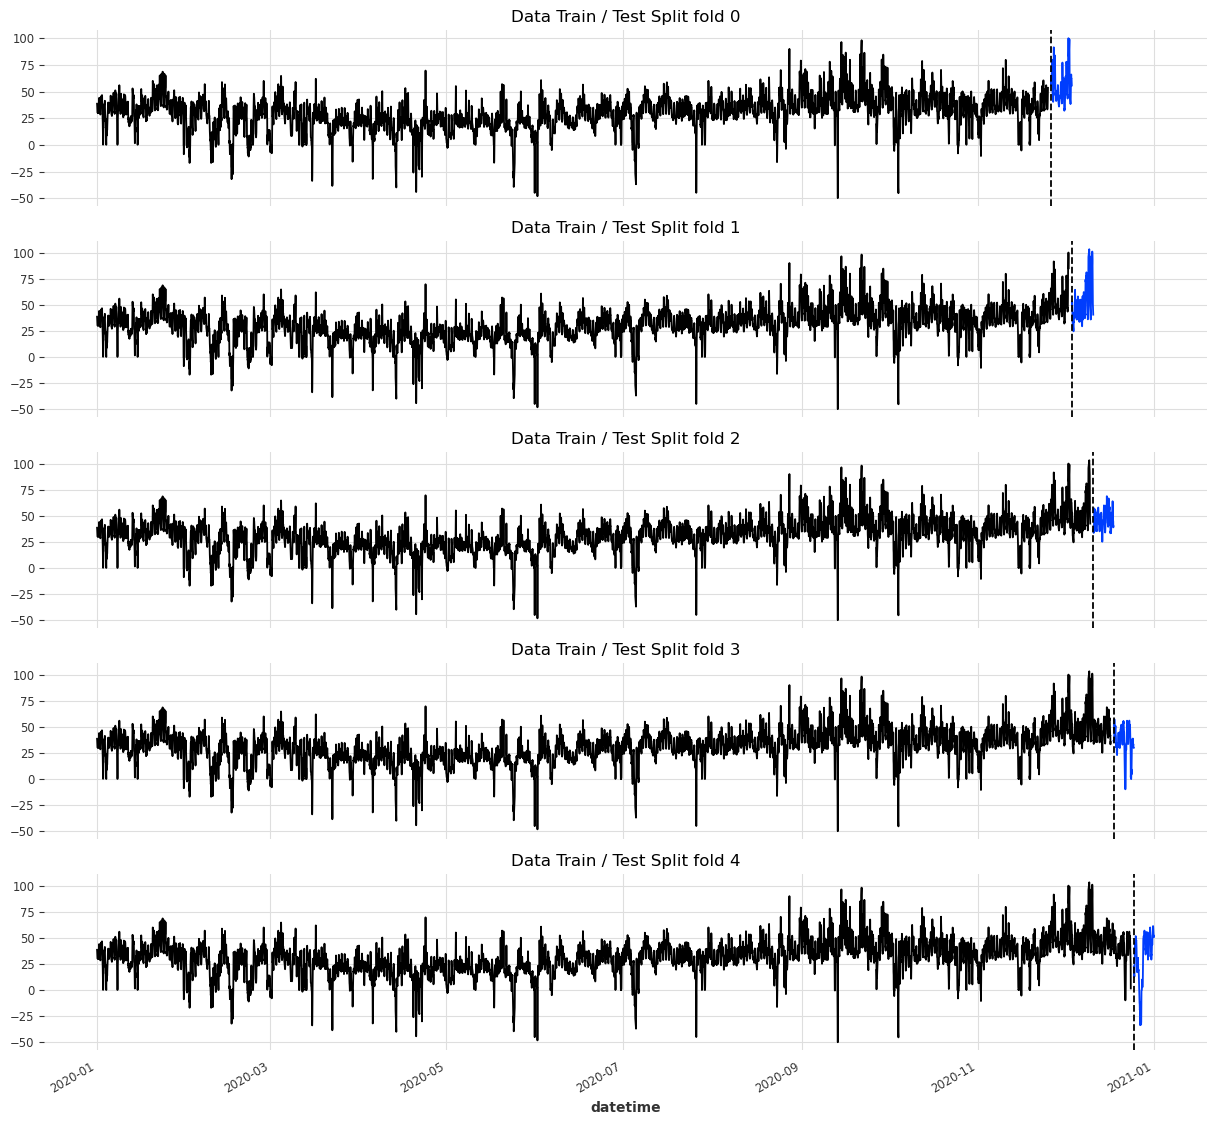

In [308]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['energy_price'].plot(ax=axs[fold], label='Training Set', title=f'Data Train / Test Split fold {fold}')
    test['energy_price'].plot(ax=axs[fold], label='Testing Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

In [309]:
fold = 0 

# creating lists of the root_mean_squared_error, the prediction and the mape to evaluate the scores later
preds = []
scores_rmse = []
scores_mape = []


for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    
    train = create_features(train)
    test = create_features(test)

    
    FEATURES_WEEK = ['hour', 'dayofweek','month']
    TARGET = ['energy_price']

    
    X_train = train[FEATURES_WEEK]
    y_train = train[TARGET]

    X_test = test[FEATURES_WEEK]
    y_test = test[TARGET]
    

    # creating the model
    # base_score = default value, initial prediction score of the model
    # booster = default value, type of boosting algorithm to use
    # n_estimators = how many trees the model is going to build
    # early_stopping_rounds = if model gets worse it will stop after 50 rounds
    # objective = loss function to be optimized during training
    # max_depth = maximum depth of each decision tree in the ensemble
    #learning_rate = shrinkage factor applied to each update of the model during training
    
    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )

    # fitting the model
    reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100
        )
    
    # predicting and adding to lists
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)

[0]	validation_0-rmse:32.00855	validation_1-rmse:55.73284
[100]	validation_0-rmse:15.78278	validation_1-rmse:33.66517
[200]	validation_0-rmse:11.44565	validation_1-rmse:26.27397
[300]	validation_0-rmse:10.32508	validation_1-rmse:23.75684
[400]	validation_0-rmse:9.88196	validation_1-rmse:22.83208
[499]	validation_0-rmse:9.64451	validation_1-rmse:22.52080
[0]	validation_0-rmse:32.61189	validation_1-rmse:52.64532
[100]	validation_0-rmse:16.07737	validation_1-rmse:30.91897
[200]	validation_0-rmse:11.66655	validation_1-rmse:21.23903
[300]	validation_0-rmse:10.55520	validation_1-rmse:16.66554
[400]	validation_0-rmse:10.12325	validation_1-rmse:14.85612
[499]	validation_0-rmse:9.89217	validation_1-rmse:14.09969
[0]	validation_0-rmse:33.09109	validation_1-rmse:46.08774
[100]	validation_0-rmse:16.29574	validation_1-rmse:19.94013
[200]	validation_0-rmse:11.78303	validation_1-rmse:9.39842
[300]	validation_0-rmse:10.62175	validation_1-rmse:6.43082
[400]	validation_0-rmse:10.18465	validation_1-rmse:

In [310]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 16.87
Fold RMSE scores: [22.52080066725364, 14.099684850925719, 5.905750916492729, 17.51394413810557, 24.334386337093125]
MAPE scores across folds 12.08
Fold MAPE scores: [0.3526335894196115, 0.20876673829038253, 0.10857706524974368, 26.511554391636288, 33.237850863829564]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.71  |12.66%  | 
| Model 3 | Results in Cross Validation |16.87  | 12.08% | 

### Lag Features - Past Covariates

- using the value from (x) hours ago as the value is unknown on the day we want to predict
- we are going to try out three different (x) hours ago to fit our model: 168 (week), 24 (day) and 1 (hour)

In [339]:
def add_lags_week(df):
    '''
    new columns for 168 hours ago
    '''
    target_map = df['energy_price'].to_dict()
    df['week_energy_price']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['week_wind_speed']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['week_solar_radiation']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['week_temperature']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['week_nuclear_power']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['week_not_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['week_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    return df

In [340]:
def add_lags_day(df):
    '''
    new columns for 24 hours ago
    '''
    target_map = df['energy_price'].to_dict()
    df['day_energy_price']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['day_wind_speed']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['day_solar_radiation']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['day_temperature']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['day_nuclear_power']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['day_not_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['day_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    return df

In [341]:
def add_lags_hour(df):
    '''
    new columns for 1 hour ago
    '''
    target_map = df['energy_price'].to_dict()
    df['hour_energy_price']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['hour_wind_speed']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['hour_solar_radiation']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['hour_temperature']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['hour_nuclear_power']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['hour_not_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['hour_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    return df

- running our DataFrame through the functions to add features

In [342]:
df = add_lags_week(df)
df = add_lags_day(df)
df = add_lags_hour(df)
df.head(3)

,wind_speed,solar_radiation,temperature,date,day_of_week,time,month,nuclear_power,not_renewable,renewable,...,day_nuclear_power,day_not_renewable,day_renewable,hour_energy_price,hour_wind_speed,hour_solar_radiation,hour_temperature,hour_nuclear_power,hour_not_renewable,hour_renewable
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2.4,0,-0.1,2020-01-01,Wednesday,00:00:00,1,8088.21750,29512.74850,14541.30200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,2.4,0,-0.5,2020-01-01,Wednesday,01:00:00,1,8081.15875,29178.66275,14949.45575,...,NaN,NaN,NaN,38.60,2.4,0.0,-0.1,8088.21750,29512.74850,14541.30200
2020-01-01 02:00:00,2.5,0,-0.7,2020-01-01,Wednesday,02:00:00,1,8071.44750,29414.36225,15077.92500,...,NaN,NaN,NaN,36.55,2.4,0.0,-0.5,8081.15875,29178.66275,14949.45575


### Train model using features and lag features data

In [315]:
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['month', 'hour', 'dayofweek', 
                'hour_energy_price', 'week_energy_price', 'day_energy_price', 
                'hour_wind_speed', 'week_wind_speed', 'day_wind_speed', 
                'hour_solar_radiation', 'week_solar_radiation', 'day_solar_radiation', 
                'hour_renewable', 'week_renewable', 'day_renewable', 
                'hour_not_renewable', 'week_not_renewable', 'day_not_renewable', 
                'hour_nuclear_power', 'week_nuclear_power', 'day_nuclear_power']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)
    fold += 1

[0]	validation_0-rmse:31.97734	validation_1-rmse:55.60724
[100]	validation_0-rmse:12.77456	validation_1-rmse:25.70531
[200]	validation_0-rmse:6.48913	validation_1-rmse:15.20612
[300]	validation_0-rmse:4.65487	validation_1-rmse:11.02380
[400]	validation_0-rmse:4.01535	validation_1-rmse:9.46219
[499]	validation_0-rmse:3.68785	validation_1-rmse:8.76683
[0]	validation_0-rmse:32.58023	validation_1-rmse:52.54644
[100]	validation_0-rmse:13.07765	validation_1-rmse:24.68409
[200]	validation_0-rmse:6.65579	validation_1-rmse:13.94839
[300]	validation_0-rmse:4.73196	validation_1-rmse:9.88963
[400]	validation_0-rmse:4.06423	validation_1-rmse:8.68502
[499]	validation_0-rmse:3.72666	validation_1-rmse:8.03603
[0]	validation_0-rmse:33.05827	validation_1-rmse:46.02468
[100]	validation_0-rmse:13.30224	validation_1-rmse:17.69707
[200]	validation_0-rmse:6.77797	validation_1-rmse:7.39350
[300]	validation_0-rmse:4.77480	validation_1-rmse:4.12036
[400]	validation_0-rmse:4.09027	validation_1-rmse:3.36232
[499]

In [316]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 6.01
Fold RMSE scores: [8.766826242220093, 8.036026569301036, 3.2433761528186706, 4.214522065041695, 5.787141842628388]
MAPE scores across folds 1.72
Fold MAPE scores: [0.06951807821259821, 0.09068680998401504, 0.05427017080482323, 5.701867695790652, 2.659345725935799]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.71  |12.66%  | 
| Model 3 | Results in Cross Validation |16.87  | 12.08% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 6.01  | 1.72%  | 

(1) Below features lagged by one week, one day and one hour are included:
- Energy price
- Wind speed
- Solar radiation
- Renewable energy feeding volume
- Not renewable energy feeding volume
- Nuclear energy feeding volume

### Feature importances

- gives us the importance based on how much the features were used in each of the trees build by model

- creating a pandas dataframe to visualize and sort by importance

<AxesSubplot:title={'center':'Feature importance by weekly features'}>

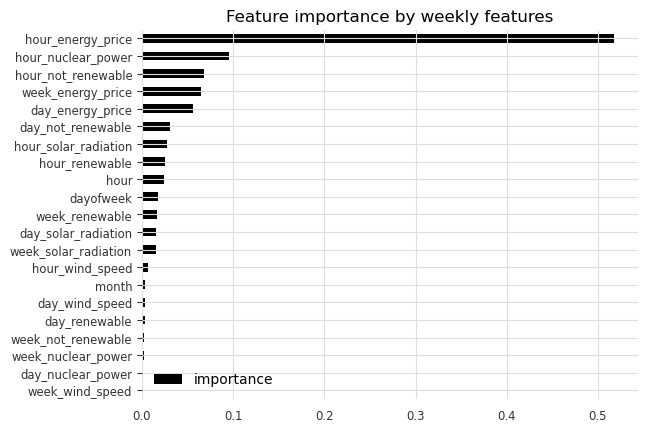

In [317]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature importance by weekly features')

### Remove least important features

In [321]:
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['hour', 'dayofweek',
                'hour_energy_price', 'week_energy_price', 'day_energy_price', 
                'hour_solar_radiation', 'day_solar_radiation',  
                'hour_not_renewable', 'day_not_renewable', 
                'hour_renewable', 'week_renewable',
                'hour_nuclear_power']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)
    fold += 1

[0]	validation_0-rmse:31.97734	validation_1-rmse:55.60724
[100]	validation_0-rmse:12.77456	validation_1-rmse:25.70531
[200]	validation_0-rmse:6.48924	validation_1-rmse:15.20546
[300]	validation_0-rmse:4.65522	validation_1-rmse:10.98836
[400]	validation_0-rmse:4.02216	validation_1-rmse:9.54453
[499]	validation_0-rmse:3.69378	validation_1-rmse:8.76133
[0]	validation_0-rmse:32.58023	validation_1-rmse:52.54644
[100]	validation_0-rmse:13.07765	validation_1-rmse:24.68409
[200]	validation_0-rmse:6.65587	validation_1-rmse:13.94900
[300]	validation_0-rmse:4.73314	validation_1-rmse:9.89689
[400]	validation_0-rmse:4.06006	validation_1-rmse:8.67127
[499]	validation_0-rmse:3.72930	validation_1-rmse:8.00767
[0]	validation_0-rmse:33.05827	validation_1-rmse:46.02468
[100]	validation_0-rmse:13.30224	validation_1-rmse:17.69707
[200]	validation_0-rmse:6.78088	validation_1-rmse:7.38247
[300]	validation_0-rmse:4.77639	validation_1-rmse:4.11709
[400]	validation_0-rmse:4.08968	validation_1-rmse:3.33582
[499]

In [322]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 6.00
Fold RMSE scores: [8.761325770669124, 8.00767022337492, 3.240815261525446, 4.2045496278631145, 5.777476303459436]
MAPE scores across folds 1.70
Fold MAPE scores: [0.06982303018589338, 0.09026366710613726, 0.054686042320881624, 5.677535818440068, 2.6192041725086237]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.71  |12.66%  | 
| Model 3 | Results in Cross Validation |16.87  | 12.08% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 6.01  | 1.72%  | 
| Model 5 | Model 3 with selected lag features(2) in Cross validation | 6.00  | 1.70%  | 

(1) Below features lagged by one week, one day and one hour are included:
- Energy price
- Wind speed
- Solar radiation
- Renewable energy feeding volume
- Not renewable energy feeding volume
- Nuclear energy feeding volume


(2) Below features are included:
- Energy price lagged by one week
- Energy price lagged by one day
- Energy price lagged by one hour
- Solar radiation lagged by one hour
- Solar radiation lagged by one day
- Renewable energy feeding volume lagged by one hour
- Renewable energy feeding volume lagged by one week
- Not renewable energy feeding volume lagged by one hour
- Not renewable energy feeding volume lagged by one week
- Nuclear energy feeding volume lagged by one hour

### Finalize and Evaluate

In [343]:
# Import dataframe
df = pd.read_csv('./data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

# Remove outliers
df = df.query('energy_price < 105').copy()
df = df.query('energy_price > -50').copy()

In [347]:
# add future covariates
def create_features(df):
    '''
    create time series features based on time series index
    '''
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

df = create_features(df)

In [344]:
# add past covariates
def add_lags_week(df):
    '''
    new columns for 168 hours ago
    '''
    target_map = df['energy_price'].to_dict()
    df['week_energy_price']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['week_wind_speed']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['week_solar_radiation']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['week_temperature']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['week_nuclear_power']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['week_not_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['week_renewable']= (df.index - pd.Timedelta('168 hours')).map(target_map)
    return df

def add_lags_day(df):
    '''
    new columns for 24 hours ago
    '''
    target_map = df['energy_price'].to_dict()
    df['day_energy_price']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['day_wind_speed']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['day_solar_radiation']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['day_temperature']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['day_nuclear_power']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['day_not_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['day_renewable']= (df.index - pd.Timedelta('24 hours')).map(target_map)
    return df

def add_lags_hour(df):
    '''
    new columns for 1 hour ago
    '''
    target_map = df['energy_price'].to_dict()
    df['hour_energy_price']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['wind_speed'].to_dict()
    df['hour_wind_speed']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['solar_radiation'].to_dict()
    df['hour_solar_radiation']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['temperature'].to_dict()
    df['hour_temperature']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['nuclear_power'].to_dict()
    df['hour_nuclear_power']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['not_renewable'].to_dict()
    df['hour_not_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    target_map = df['renewable'].to_dict()
    df['hour_renewable']= (df.index - pd.Timedelta('1 hour')).map(target_map)
    return df

df = add_lags_week(df)
df = add_lags_day(df)
df = add_lags_hour(df)

In [348]:
# Train / Test split
# We use the last week of the data as test data
one_week = 168
train, test = df[:-one_week], df[-one_week:]

# Add features and set target
FEATURES = ['hour', 'dayofweek',
                'hour_energy_price', 'week_energy_price', 'day_energy_price', 
                'hour_solar_radiation', 'day_solar_radiation',  
                'hour_not_renewable', 'day_not_renewable', 
                'hour_renewable', 'week_renewable',
                'hour_nuclear_power']
TARGET = 'energy_price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Create a model
reg = xgb.XGBRegressor(
    gamma=0.1,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    random_state=0
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Make prediction
y_pred = reg.predict(X_test)

# Evaluate the model
score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score_mape = (mean_absolute_percentage_error(y_test, y_pred))

[0]	validation_0-rmse:33.61055	validation_1-rmse:38.89152
[100]	validation_0-rmse:13.50177	validation_1-rmse:15.81062
[200]	validation_0-rmse:6.77608	validation_1-rmse:8.37434
[300]	validation_0-rmse:4.77697	validation_1-rmse:6.64677
[400]	validation_0-rmse:4.08312	validation_1-rmse:6.02300
[499]	validation_0-rmse:3.74650	validation_1-rmse:5.81728


C:\Users\zawad\AppData\Local\Temp\ipykernel_12228\2009793266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred


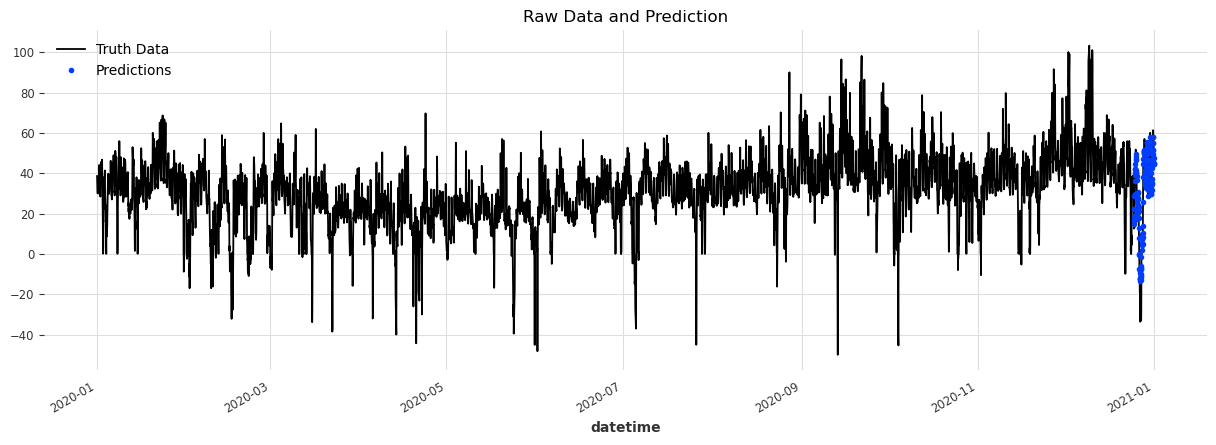

In [349]:
test['y_pred'] = y_pred
df = df.merge(test[['y_pred']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['y_pred'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [350]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['y_pred']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['y_pred']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 5.82
MAPE Score on test set: 2.64


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.71  |12.66%  | 
| Model 3 | Results in Cross Validation |16.87  | 12.08% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 6.01  | 1.72%  | 
| Model 5 | Model 3 with selected lag features(2) in Cross validation | 6.00  | 1.70%  | 
| Model 5 | Model 5, train : test = 8735 : 168 | 5.82 | 2.64%  |

### 8. Training model on all data

- Retraining on all given data except weekly and daily as the mape was not good and taking out the least important features

In [357]:
df = create_features(df)

#using all the data we have to create features 
FEATURES = ['month', 'dayofweek', 'hour', 
            'hour_solar_radiation', 
            'hour_wind_speed', 
            'hour_temperature', 
            'hour_not_renewable', 
            'hour_renewable', 
            'hour_nuclear_power', 
            'day_temperature', 
            'day_solar_radiation', 
            'day_wind_speed',
            'day_not_renewable', 
            'day_renewable', 
            'day_nuclear_power', 
            'week_solar_radiation', 
            'week_temperature',
            'week_wind_speed',
            'week_not_renewable', 
            'week_renewable', 
            'week_nuclear_power']

TARGET = ['energy_price']

# "splitting" the data into features and target data
X_all = df[FEATURES]
y_all = df[TARGET]

# creating the model
# base_score = default value, initial prediction score of the model
# booster = default value, type of boosting algorithm to use
# n_estimators = how many trees the model is going to build
# early_stopping_rounds = if model gets worse it will stop after 50 rounds
# objective = loss function to be optimized during training
# max_depth = maximum depth of each decision tree in the ensemble
#learning_rate = shrinkage factor applied to each update of the model during training
reg = xgb.XGBRegressor(base_score = 0.5, 
                        booster= 'gbtree',
                        n_estimators=500,  
                        objective = 'reg:linear',
                        max_depth = 3,
                        learning_rate=0.01)

#fitting the model
reg.fit(X_all, y_all,
        eval_set = [(X_all, y_all)],
        verbose=100
        )

# predicting 
y_pred = reg.predict(X_all)

#ALL data week, day, hour
#299868582462780.50%

#ALL data ohne temp
#255337951030853.31%

#ALL data ohne temp + wind_speed
#253966097140080.41%

#ALL data ohne temp + wind_speed + solar
#267690005177139.00%

[00:03:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.73167
[100]	validation_0-rmse:14.59527
[200]	validation_0-rmse:8.65107
[300]	validation_0-rmse:6.85854
[400]	validation_0-rmse:6.14012
[499]	validation_0-rmse:5.75744


- creating future dataframe and run through feature creation code + lag creation

In [353]:
#creating the hourly daterange for one week in the future of new year (2021)
future = pd.date_range('2020-12-31', '2021-01-08', freq='1h')
future_df = pd.DataFrame(index=future)

# adding True and False for isFuture to see easily inside the dataframe if the value is the future or not 
future_df['isFuture'] = True
df['isFuture'] = False

# adding the future and past covariates into our dataframe
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags_week(df_and_future)
df_and_future = add_lags_day(df_and_future)
df_and_future = add_lags_hour(df_and_future)

In [354]:
future_w_features = df_and_future.query('isFuture').copy()

### 9. Predicting the Future

- predicting the future with all the future and past covariates we created

In [355]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

- visualizing the predicted future

<AxesSubplot:title={'center':'Future Prediction'}>

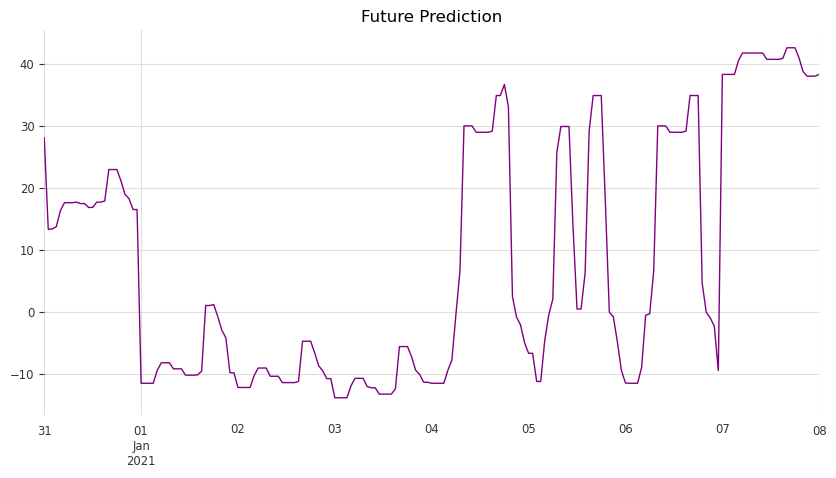

In [356]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color = 'purple',
                               ms = 1,
                               lw= 1,
                               title= 'Future Prediction')